Sieci CNN- zadanie klasyfikacji, augmentacja danych, wizualizacja filtrów

Celem czwartych zajęć laboratoryjnych jest przetestowanie podstawowych koncepcji dotyczących architektury i działania sieci splotowych implementowanych w środowisku PyTorch. Standard postępowania opisany jest w rozdziale 4 udostępnionej książki (potrzebne tutaj ogólne koncepcje techniczne związane z biblioteką PyTorch prezentuje rozdział 2).
Zadanie polega na zbudowaniu sieci klasyfikacyjnej dla danych obrazowych z co najmniej 5 klasami. Oprócz standardowych wizualiacji dokładnościowych należy wykonać augmentację danych oraz wizualizację filtrów splotowych. Dane reprezentują obrazy liści dostępne w bazie plantvillage-dataset.

In [3]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.manifold import TSNE
import seaborn as sns


In [4]:
# 1. Ścieżka do danych (dostosuj do swojego środowiska)
data_path = "plantvillage dataset/grayscale"

# 2. Wybrane klasy (dokładnie odpowiadają nazwom folderów w zbiorze)
selected_classes = [
    "Apple___healthy",
    "Apple___Black_rot",
    "Cherry_(including_sour)___healthy",
    "Corn_(maize)___Common_rust",
    "Grape___healthy"
]


In [5]:
# 3. Transformacje i augmentacja
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Model oczekuje 1-kanałowych obrazów
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor()
])

In [6]:
# 4. Wczytanie pełnego datasetu
full_dataset = datasets.ImageFolder(root=data_path, transform=transform)

In [7]:
# 5. Utworzenie niestandardowego datasetu filtrującego wybrane klasy 
class FilteredDataset(Dataset):
    def __init__(self, dataset, selected_classes):
        self.dataset = dataset
        # Utwórz mapping: oryginalny indeks klasy -> nowy indeks
        # Upewnij się, że nazwa klasy (folder) jest taka sama jak w selected_classes
        self.class_to_new_label = {}
        for new_label, class_name in enumerate(selected_classes):
            if class_name in dataset.classes:
                orig_label = dataset.classes.index(class_name)
                self.class_to_new_label[orig_label] = new_label
        
        # Lista indeksów próbek, których etykieta znajduje się w wybranych klasach
        self.indices = [i for i, (path, label) in enumerate(dataset.samples)
                        if label in self.class_to_new_label]
    
    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, idx):
        real_idx = self.indices[idx]
        img, orig_label = self.dataset[real_idx]
        new_label = self.class_to_new_label[orig_label]
        return img, new_label

filtered_dataset = FilteredDataset(full_dataset, selected_classes)

# 6. Podział na zbiór treningowy i testowy
train_size = int(0.8 * len(filtered_dataset))
test_size = len(filtered_dataset) - train_size
train_set, test_set = torch.utils.data.random_split(filtered_dataset, [train_size, test_size])

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32)

In [8]:
# 7. Definicja sieci CNN
class CNN(nn.Module):
    def __init__(self, num_classes=5):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # x: [B, 1, 128, 128]
        x = self.pool(F.relu(self.conv1(x)))  # -> [B, 16, 64, 64]
        x = self.pool(F.relu(self.conv2(x)))  # -> [B, 32, 32, 32]
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [9]:
# 8. Trening modelu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN(num_classes=5).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

for epoch in range(5):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1} - Loss: {running_loss:.4f}")



Epoch 1 - Loss: 92.2750
Epoch 2 - Loss: 49.9950
Epoch 3 - Loss: 39.3504
Epoch 4 - Loss: 28.4946
Epoch 5 - Loss: 24.7660


In [10]:

# 9. Ewaluacja modelu
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

acc = accuracy_score(all_labels, all_preds)
print(f"\nDokładność na zbiorze testowym: {acc:.4f}")


Dokładność na zbiorze testowym: 0.8858


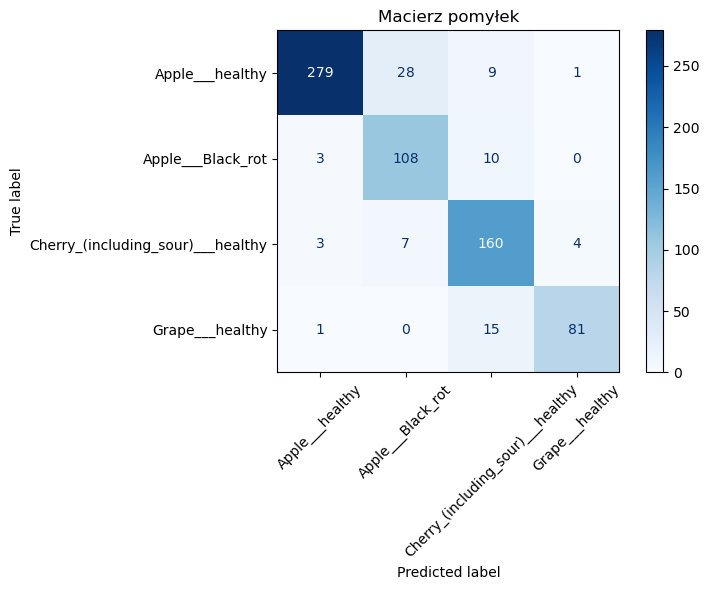

In [11]:
# Macierz pomyłek
cm = confusion_matrix(all_labels, all_preds)
unique_classes = sorted(set(all_labels + all_preds))
labels_for_display = [selected_classes[i] for i in unique_classes]

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_for_display)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap="Blues", xticks_rotation=45)
plt.title("Macierz pomyłek")
plt.tight_layout()
plt.show()

In [12]:
# Wyodrębnianie embeddingów
features, labels = [], []
model.eval()
with torch.no_grad():
    for images, lbls in test_loader:
        images = images.to(device)
        x = model.pool(F.relu(model.conv1(images)))
        x = model.pool(F.relu(model.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(model.fc1(x))
        features.append(x.cpu().numpy())
        labels.extend(lbls.numpy())

features = np.concatenate(features, axis=0)

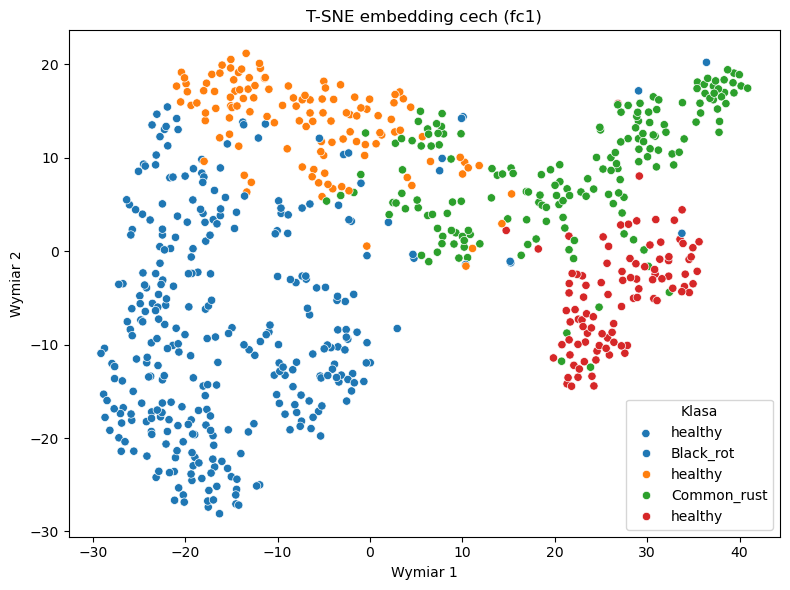

In [13]:
# T-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_results = tsne.fit_transform(features)

# Wizualizacja
plt.figure(figsize=(8, 6))
sns.scatterplot(x=tsne_results[:,0], y=tsne_results[:,1], hue=labels, palette="tab10", legend="full")
plt.title("T-SNE embedding cech (fc1)")
plt.xlabel("Wymiar 1")
plt.ylabel("Wymiar 2")
plt.legend(title="Klasa", loc='best', labels=[c.split("___")[-1] for c in selected_classes])
plt.tight_layout()
plt.show()


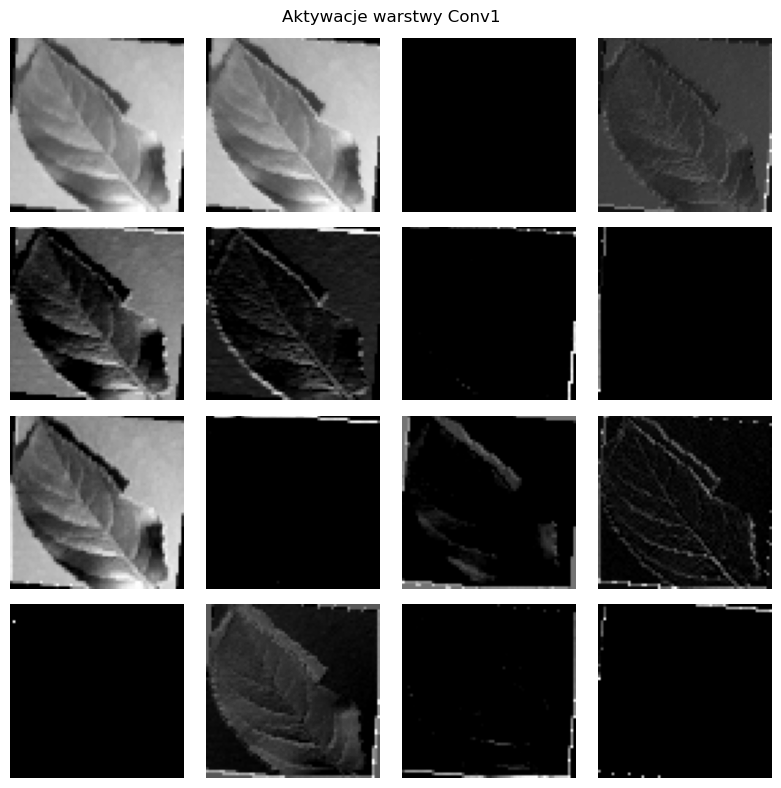

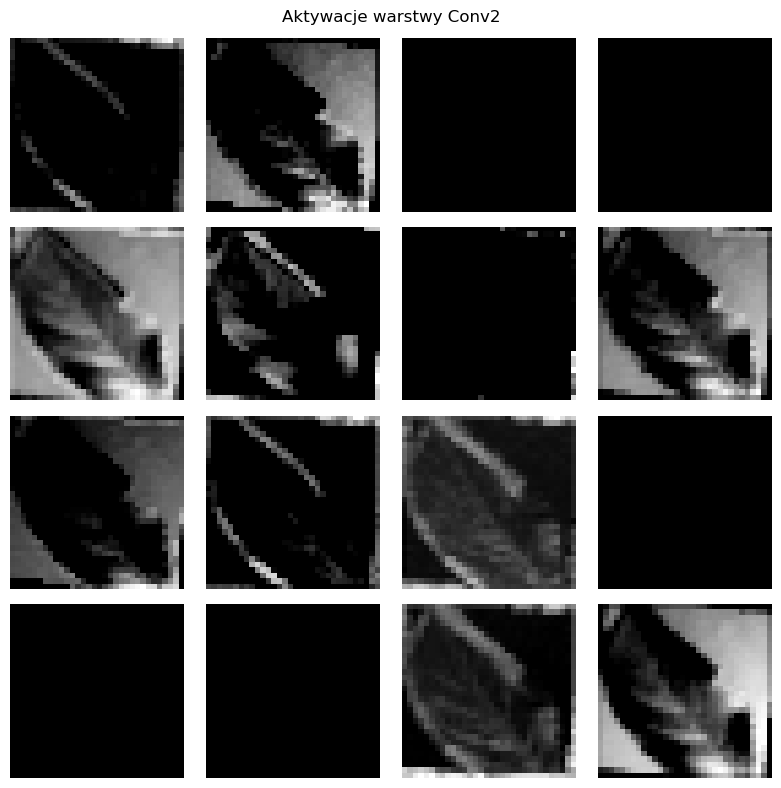

In [14]:
# Wizualizacja aktywacji dla pierwszego obrazu ze zbioru testowego
def show_activations(model, image):
    model.eval()
    image = image.unsqueeze(0).to(device)  # dodaj wymiar batch
    with torch.no_grad():
        act1 = model.pool(F.relu(model.conv1(image)))
        act2 = model.pool(F.relu(model.conv2(act1)))

    # Warstwa 1
    fig, axs = plt.subplots(4, 4, figsize=(8, 8))
    for i, ax in enumerate(axs.flat):
        if i >= act1.shape[1]:
            break
        ax.imshow(act1[0, i].cpu(), cmap="gray")
        ax.axis("off")
    plt.suptitle("Aktywacje warstwy Conv1")
    plt.tight_layout()
    plt.show()

    # Warstwa 2
    fig, axs = plt.subplots(4, 4, figsize=(8, 8))
    for i, ax in enumerate(axs.flat):
        if i >= act2.shape[1]:
            break
        ax.imshow(act2[0, i].cpu(), cmap="gray")
        ax.axis("off")
    plt.suptitle("Aktywacje warstwy Conv2")
    plt.tight_layout()
    plt.show()

# Przykład – wizualizacja dla jednej próbki
sample_img, _ = next(iter(test_loader))
show_activations(model, sample_img[0])



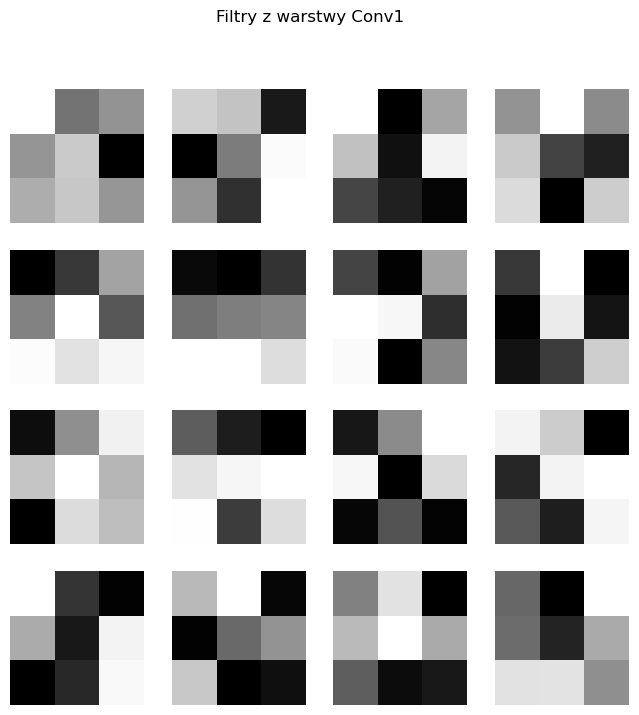

In [15]:
# 10. Wizualizacja filtrów z Conv1
filters = model.conv1.weight.data.cpu()

fig, axs = plt.subplots(4, 4, figsize=(8, 8))
for i, ax in enumerate(axs.flat):
    if i >= filters.shape[0]:
        break
    ax.imshow(filters[i][0], cmap="gray")
    ax.axis("off")
plt.suptitle("Filtry z warstwy Conv1")
plt.show()
